In [5]:
# -*- coding: utf-8 -*-
# based on https://danijar.com/variable-sequence-lengths-in-tensorflow/

import numpy as np
import random
import functools
import tensorflow as tf
import time
import os #os.environ

from tensorflow.python.ops import rnn_cell, rnn
from sklearn.metrics import confusion_matrix #compute confusion_matrix
from matplotlib import pyplot as plt #display confusion_matrix
from sklearn.model_selection import train_test_split #for training/validation set creation
from myfunctions import action_to_group, get_group_labels, read_data, read_config, num_to_idx 

#family = 'Object' 
family ='Motion'

#directory = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/grouping_1/'
directory = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/grouping_2/'

label_location = directory + 'labels/' + family + '_group_labels.txt' 
directory_dataset = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/data_nathan/'
file_training = "training.txt"
file_testing = "testing.txt" 

feat_size = 63 #21 joints * 3 dimensions (xyz)
batch_size = 20
padding_size = 300

# Parameters
learning_rate = 0.003
n_epochs = 200

# Network Parameters
seq_max_len = padding_size # Sequence max length
n_hidden = 100 # hidden layer num of features
p_dropout = 0.5

#Load global variables (used everywhere)
(atog, gtoa, g_labels) = action_to_group(label_location, family)
groups_with_subnet =  [i for i, value in enumerate(gtoa) if len(value)>1]
groups_without_subnet =  [i for i, value in enumerate(gtoa) if len(value)==1]
num_classes = max(atog) + 1 #or len(g_labels) 

#Sanity check
print (str(num_classes)+ ' classes: [' + ', '.join(g_labels) + ']\n')
location = directory + 'labels/name_of_labels_original.txt'
for i in range(num_classes): #visualise the whole grouping of 45 actions at once as a nested list
    print(get_group_labels(location,atog,i))
    
print(groups_with_subnet)
print(groups_without_subnet)

13 classes: [use, clean, close, do, flip, meet, open, pour, prick, sprinkle, insert, takeout, squeeze]

['charge_cell_phone', 'light_candle', 'use_calculator', 'use_flash', 'write']
['clean_glasses', 'wash_sponge']
['close_juice_bottle', 'close_liquid_soap', 'close_milk', 'close_peanut_butter']
['drink_mug', 'scratch_sponge', 'stir', 'tear_paper']
['flip_pages', 'flip_sponge']
['give_card', 'give_coin', 'handshake', 'high_five', 'receive_coin', 'toast_wine']
['open_juice_bottle', 'open_letter', 'open_liquid_soap', 'open_milk', 'open_peanut_butter', 'open_soda_can', 'open_wallet']
['pour_juice_bottle', 'pour_liquid_soap', 'pour_milk', 'pour_wine']
['prick', 'scoop_spoon']
['put_salt', 'sprinkle']
['put_sugar', 'put_tea_bag']
['read_letter', 'take_letter_from_enveloppe', 'unfold_glasses']
['squeeze_paper', 'squeeze_sponge']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[]


**Function definitions**

In [6]:
#Called to load training/testing data 
def create_dataset(filename, group_number):
    # dataset is organized as NxLxD (N = num samples, L temporal length with padding, D feature dimension
    # labels is NxY where Y is one hot label vector
    
    # -3 sends back labels as actions number (0..45) with one hot enconding (000..1..00)
    # -2 sends back labels as actions number (0..45) with no one hot enconding (1 or 2 or 45)
    # -1 sends back labels as groups number (0..12or26) with one hot encoding (000..1..00)
    # 0> sends back labels of only this group with one hot enconding

    dataset, labels, lengths = [], [], []
    files = read_config(filename)
    
    if group_number == -3: #standard 45 actions RNN
        num_classes = 45
    elif group_number == -2: #groupRNN to subnets (testing phase)
        #num_classes = 45 #not needed in the function when -2 activated
        pass
    elif group_number == -1: #groupRNN
        num_classes = max(atog) + 1 
        #pass
    else: #subnets
        list_actions = gtoa[group_number] #gives list of actions in current group number
        num_classes = len(list_actions)
        
    for i in files:
        
        if group_number == -3:  #standard 45 actions RNN
            
            tmp_data = read_data(directory_dataset + i[0]) #i[0] =  a01s01r01.txt (for eg)
            num =  int( i[1] )
            tmp_labels = np.transpose(num_to_idx(num, num_classes)) #one hot encoding
        
        elif group_number == -2: #Feed output of groupRNN to pre-trained subnet (testing phase)
            
            tmp_data = read_data(directory_dataset + i[0]) #i[0] =  a01s01r01.txt (for eg)
            tmp_labels = int(i[1]) #will one hot later as first need to dispatch data to relevant subnet using labels
        
        elif group_number == -1: #Build groupRNN
            
            tmp_data = read_data(directory_dataset + i[0]) 
            num =  atog[ int( i[1] )] #only used for one hot encoding in the line below
            tmp_labels = np.transpose(num_to_idx(num, num_classes)) 
            #i[0] =  a01s01r01.txt (for eg)
            #i[1] = number between 0 and 44 (or as many classes there is)
            #tmp_labels = [0, 0, 1, 0, .. 0] = one-hot encoding of class value
            #tmp_data = list with variable len around 300 & each item in the list is a nested list of len 63 (=feat_size)
        
        else: #Build subnet RNN
            
            num = int( i[1] ) #original action number
            if num in list_actions: #select data only if belongs to group 
                tmp_data = read_data(directory_dataset + i[0]) #add to dataset if part of the group
                tmp_labels = np.transpose(num_to_idx(list_actions.index(num), num_classes)) #add labels as well     
            else: continue
            
        if len(tmp_data)<300: #why 300, is that the longest sequence ? 300 = padding_size btw...
            
            #records tmp_data initial length before padding
            #pads tmp_data with zeros until padding_size (300) so len(tmp_data) = 300 always with len 63 items
                
            lengths.append(len(tmp_data))
            tmp_data.extend([ [0.0] * feat_size ] * (padding_size - len(tmp_data)))  

            dataset.append(tmp_data)
            labels.append(tmp_labels) 
        
    # all 0..565 lists with item as nested lists of size (300, 26, 1)
    return dataset, labels, lengths

In [12]:
#Called once when training RNN
def batch_generation(data,labels,lengths):
    
    num_classes = np.size(labels,1) #labels is a one hot encoded numpy array. This returns number of columns (=groups).
    
    nsamples,_,_ = data.shape

    indices = np.arange(nsamples) #np.arange(3) -> array([0, 1, 2])
    np.random.shuffle(indices) #shuffle the indices
    num_batches = int(np.floor(nsamples/batch_size)) #round to inferior number so = 0 if batch_size bigger than nsamples
    not_exact = 0

    if nsamples%batch_size != 0: #happens all the time unless nsamples is lucky multiple of batch_size
        not_exact = 1
    
    #declare empty arrays to contain the batches, dimensions are right
    batches_data = np.empty(shape=[num_batches+not_exact,batch_size,padding_size,feat_size])
    batches_labels = np.empty(shape=[num_batches+not_exact,batch_size,num_classes]) 
    batches_lengths = np.empty(shape=[num_batches + not_exact, batch_size],dtype=np.int32)

    for x in range(num_batches):
        batches_data[x, :, :, :] = data[indices[batch_size*x:batch_size*(x+1)], :, :]
        batches_labels[x,:,:] = labels[indices[batch_size*x:batch_size*(x+1)], :]
        batches_lengths[x,:] = lengths[indices[batch_size*x:batch_size*(x+1)]]

    if not_exact > 0:
        
        to_complete = nsamples%batch_size
        
        #nsamples is too small, reuse the samples from previous batch, taken randomly to complete this batch
        tmp_random = np.random.randint(0,nsamples,batch_size-to_complete) # we complete last batch with random samples
        #prints list of indices it will take randomly
        
        #[num_batches] refers to the last batch that is not complete
        tmp_data = data[indices[batch_size*num_batches:batch_size*num_batches+to_complete],:,:]
        batches_data[num_batches]=np.concatenate((tmp_data,data[tmp_random,:,:]),axis=0)

        tmp_labels = labels[indices[batch_size*num_batches:batch_size*num_batches+to_complete],:]
        batches_labels[num_batches] = np.concatenate((tmp_labels,labels[indices[tmp_random],:]))
        
        tmp_lengths = lengths[indices[batch_size*num_batches:batch_size*num_batches+to_complete]]
        batches_lengths[num_batches] = np.concatenate((tmp_lengths,lengths[indices[tmp_random]]))

    return batches_data, batches_labels, batches_lengths, num_batches+not_exact

In [13]:
def dynamicRNN(x, seqlen, weights, biases, keep_prob):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, feat_size])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(x, seq_max_len, 0) # tf.split(value, num_or_size_splits, axis)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
    
    #Operator adding dropout to inputs and outputs of the given cell.
    lstm_cell_dropout = rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob = keep_prob) 
    
    #Added to have 2 layers LSTM, not used here.
    layers = 1
    final_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell_dropout] * layers)

    # Get lstm cell output, providing 'sequence_length' will perform dynamic calculation.
    outputs, states = tf.contrib.rnn.static_rnn(final_cell, x, dtype=tf.float32, sequence_length=seqlen)
    
    # When performing dynamic calculation, we must retrieve the last
    # dynamically computed output, i.e, if a sequence length is 10, we need
    # to retrieve the 10th output.
    # However TensorFlow doesn't support advanced indexing yet, so we build
    # a custom op that for each sample in batch size, get its length and
    # get the corresponding relevant output.

    # 'outputs' is a list of output at every timestep, we pack them in a Tensor
    # and change back dimension to [batch_size, n_step, n_input]
    outputs = tf.stack(outputs)
    outputs = tf.transpose(outputs, [1, 0, 2])

    # Hack to build the indexing and retrieve the right output.
    batch_size = tf.shape(outputs)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size) * seq_max_len + (seqlen - 1)
    # Indexing
    outputs = tf.gather(tf.reshape(outputs, [-1, n_hidden]), index)

    # Linear activation, using outputs computed above
    return tf.matmul(outputs, weights['out']) + biases['out']

In [14]:
def doMyRNN(family, group_number):
    
    # group_number = 
    # -3 training stanard 45 actions RNN
    # -2 never
    # -1 training groupRNN
    # 0> training subnet

    # ==========
    #   MODEL
    # ==========
    print('in MODEL')

    tf.reset_default_graph() #Clear computational graph to prevent error
    
    # Load training and testing data
    train_data, train_labels, train_lengths = create_dataset(file_training, group_number)
    test_data, test_labels, test_lengths = create_dataset(file_testing, group_number)
    
    #cast to numpy array
    train_data = np.asarray(train_data)
    train_labels = np.asarray(train_labels)
    train_lengths = np.asarray(train_lengths,dtype=np.int32)
    test_data = np.asarray(test_data)
    test_labels = np.asarray(test_labels)
    test_lengths = np.asarray(test_lengths)
    
    #Set validation/training split
    tr_data, val_data, tr_labels, val_labels, tr_lengths, val_lengths = train_test_split(train_data, train_labels, train_lengths, 
                                                                                            test_size=0.2, random_state=42, stratify=train_labels)

    (samples, rows, row_size) = train_data.shape

    n_classes = np.size(train_labels,1)

    # tf Graph input
    x = tf.placeholder("float", [None, seq_max_len, feat_size], name="x")
    y = tf.placeholder("float", [None, n_classes], name="y")

    # A placeholder for indicating each sequence length
    seqlen = tf.placeholder(tf.int32, [None], name="seqlen")

    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")

    # ==========
    #   LAUNCH
    # ==========
    print('in LAUNCH')

    pred = dynamicRNN(x, seqlen, weights, biases, keep_prob)

    # Evaluate model 
    prediction = tf.argmax(pred,axis=1, name="prediction") # for each prediction, keep class with highest level of confidence (tests X classes)
    correct_pred = tf.equal(prediction, tf.argmax(y,1)) #output 0 & 1 vector, y is supposed to have true labels
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) #mean of above

    #Create a saver object which will save all the variables
    #saver = tf.train.Saver()

    # ============
    #   OPTIMIZE
    # ============
    print('in OPTIMIZE \n')

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y))
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    # optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()
    
    #Create a saver object which will save all the variables
    saver = tf.train.Saver() 
    if group_number == -3 :
        saved_path = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/grouping_0/'
    elif group_number == -1 :
        saved_path = directory + 'saved_sessions/group_RNN/' + family 
    else:
        saved_path = directory + 'saved_sessions/subnets/' + family + '/subnet_' + str(group_number)

    # Launch the graph
    with tf.Session() as sess:

        sess.run(init)

        max_acc = 0.0;
        max_epoch = 0;
        best_labels = []

        # Keep training until reach max iterations
        for epoch in range(n_epochs):
            
            (batch_x, batch_y, batch_seqlen, n_batches) = batch_generation(tr_data, tr_labels, tr_lengths)

            start = time.time()

            for i in range(n_batches):

                # Run optimization op (backprop)
                sess.run(optimizer, feed_dict={x: batch_x[i,:,:,:], y: batch_y[i,:,:],
                                               seqlen: batch_seqlen[i,:], keep_prob: p_dropout})

            # Test accuracy on this epoch    
            validation_acc = sess.run(accuracy, feed_dict={x: val_data, y: val_labels, seqlen: val_lengths, keep_prob: 1.0})

            #Save best validation results
            if validation_acc > max_acc: 
                
                max_acc = validation_acc; max_epoch = epoch
                    
                #Save best model of the NN
                saver.save(sess, saved_path)
                print('Saved subnet at epoch ' + str(epoch) + ' at ' + saved_path)

            print('Epoch {:2d} validation accuracy {:3.1f}% in {:3.1f} seconds'.format(epoch, 100 * validation_acc, time.time() - start))
            print('max_acc {:3.1f}% at epoch {:2d} \n'.format(max_acc*100, max_epoch))
            
            #Stop training when accuracy is maximum
            if max_acc == 1: 
                print('Reached 100% accuracy -> exit training \n')
                break
             
        print ("Optimization Finished! \n")

        # ToDo
        # Get training accuracy and plot it along validation accuracy and test accuracy


In [15]:
#Display confusion matrix
def confusion_mtx(true, pred, name_labels):
    
    num_classes = len(name_labels)
    cm = confusion_matrix(true, pred)

    fig = plt.figure(figsize=(10,10), dpi=100)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    plt.xticks(range(num_classes), name_labels, rotation=90)
    plt.yticks(range(num_classes), name_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    #TODO
    #Adjust the matrix scale (0 to 45 to the relevant scaling 0 to 100%)
    #Have a checkerboard figure to track classes easily
    #Have white background for better error reading for colorbar
    #Rotate 45 the vertical axis
    #Write number of successful matches inside the box (especially good for subnets)

#Display confidence level bar histogram 
def confidence_probability_g (scores, pred_class, true_class, g_labels):
    
    format_scores = scores - np.amin(scores)
    format_scores = format_scores / np.amax(format_scores)
    
    #y = scores
    y = format_scores #probabilities made from normalising on this 1 score (not on the 569 scores)
    x = range(len(scores)) #as much scores as there is in y (45)
    
    plt.figure(figsize=(20,4))
    
    barlist = plt.bar(x,y, width=0.7)

    import randomcolor
    colors = randomcolor.RandomColor().generate(count=num_classes) #as many group or actions    
    for i in range(len(barlist)): barlist[i].set_color(colors[i])
    
    plt.title('Predicted class ' + str(pred_class) + ' ' + g_labels[pred_class] 
                 + ' for class ' + str(true_class) + ' ' + g_labels[true_class],
                 fontsize=18)
    
    plt.xticks(x, g_labels, rotation=90, fontsize=18)
    
    plt.show()
    
    #ToDo
    # Be able to know the name of sample seq that fails 
    
def compute_accuracy(groups, pred_labels, test_labels):
    
    indices = [index for index, value in enumerate(pred_labels) if value in groups]
    p, t = pred_labels[indices], test_labels[indices]
    group_t = [atog[value] for value in t] #convert t labels from action to group number for comparison with p
    
    correct_pred = np.equal(p, group_t)
    
    return correct_pred

In [16]:
def useSubnet(group_number, pred_labels, test_data, test_labels, test_lenghts):
    
    #Alreaedy done in create dataset by using: (sub_test_data, sub_test_labels, sub_test_lengths) = create_dataset(file_testing, group_number)
    #Select relevant subset of data, labels and lengths to use on subnet
    indices = [index for index, value in enumerate(pred_labels) if value == group_number]
    (sub_test_data, sub_test_labels, sub_test_lengths) = test_data[indices], test_labels[indices], test_lengths[indices]
    #sub_test_labels is the subnet truth label to compare to subnet output
    
    tf.reset_default_graph() #Clear computational graph to prevent error
    
    #Load pre-trained subnet
    sess=tf.Session()    
    location = directory + 'saved_sessions/subnets/' + family + '/subnet_' + str(group_number)
    saver = tf.train.import_meta_graph(location + ".meta")
    saver.restore(sess, location)
    graph = tf.get_default_graph()
    
    #Import variables
    x = graph.get_tensor_by_name("x:0")
    y = graph.get_tensor_by_name("y:0")
    seqlen = graph.get_tensor_by_name("seqlen:0")
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    
    #Pass test samples through RNN
    feed_dict={x: sub_test_data, seqlen: sub_test_lengths, keep_prob: 1.0} 
    prediction = graph.get_tensor_by_name("prediction:0")
    sub_pred_labels = sess.run(prediction, feed_dict) 
    
    #Convert output back to original action number 
    list_actions = gtoa[group_number] 
    original_sub_pred_labels = [list_actions[i] for i in sub_pred_labels] 
    #assumes number of subnet output is same order as actions in gtoa...
    
    #Compute results
    correct_pred = np.equal(original_sub_pred_labels, sub_test_labels) #output 0 & 1 vector
    accuracy_with = np.mean(correct_pred)
    
    print("Accuracy subnet %i %s is %.2f %%" % (group_number, g_labels[group_number], float(100*accuracy_with)) )
    #onfusion_mtx(original_sub_pred_labels, sub_test_labels, g_labels[group_number])
    
    return correct_pred

In [17]:
def useGroupRNN():
    
    (test_data, test_labels, test_lengths) = create_dataset(file_testing, -1)
    true_labels = np.asarray( [ np.where(r==1)[0][0] for r in test_labels ], dtype=np.int64) #one hot to action number
    
    tf.reset_default_graph() #Clear computational graph to prevent error
    
    #Load pre-trained subnet
    sess=tf.Session()    
    location = directory + 'saved_sessions/group_RNN/' + family 
    saver = tf.train.import_meta_graph(location + ".meta")
    saver.restore(sess, location)
    graph = tf.get_default_graph()
    
    #Import variables
    x = graph.get_tensor_by_name("x:0")
    y = graph.get_tensor_by_name("y:0")
    seqlen = graph.get_tensor_by_name("seqlen:0")
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    
    #Pass test samples through RNN
    feed_dict={x: test_data, seqlen: test_lengths, keep_prob: 1.0} 
    prediction = graph.get_tensor_by_name("prediction:0")
    pred_labels = sess.run(prediction, feed_dict) 
    
    #Compute results
    correct_pred = np.equal(pred_labels, true_labels) #output 0 & 1 vector
    accuracy = np.mean(correct_pred)
    print("Accuracy groupRNN %s with %i classes is %.2f %%" % (family, num_classes, float(100*accuracy))) 
    confusion_mtx(true_labels, pred_labels, g_labels)
    
    return pred_labels

In [30]:
def useStandardRNN():
    
    (test_data, test_labels, test_lengths) = create_dataset(file_testing, -3) #sends back 45 actions and one hot labels
    true_labels = np.asarray( [ np.where(r==1)[0][0] for r in test_labels ], dtype=np.int64) #one hot to action number
    
    tf.reset_default_graph() #Clear computational graph to prevent error
    
    #Load pre-trained subnet
    sess=tf.Session()    
    location = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/grouping_0/'
    saver = tf.train.import_meta_graph(location + ".meta")
    saver.restore(sess, location)
    graph = tf.get_default_graph()
    
    #Import variables
    x = graph.get_tensor_by_name("x:0")
    y = graph.get_tensor_by_name("y:0")
    seqlen = graph.get_tensor_by_name("seqlen:0")
    keep_prob = graph.get_tensor_by_name("keep_prob:0")
    
    #Pass test samples through RNN
    feed_dict={x: test_data, seqlen: test_lengths, keep_prob: 1.0} 
    prediction = graph.get_tensor_by_name("prediction:0")
    pred_labels = sess.run(prediction, feed_dict) 
    
    # Extract label names from text file
    with open(directory + 'labels/name_of_labels_original.txt') as f:
        name_labels = [word for line in f for word in line.split()]
    
    #Compute results
    correct_pred = np.equal(pred_labels, true_labels) #output 0 & 1 vector
    accuracy = np.mean(correct_pred)
    num_classes = max(true_labels)+1 #should be 45
    print("Accuracy groupRNN %s with %i classes is %.2f %%" % (family, num_classes, float(100*accuracy))) 
    confusion_mtx(true_labels, pred_labels, name_labels)
    
    return pred_labels, true_labels

In [31]:
def evaluate_grouping (pred_labels, true_labels, atog, g_labels, family):
    
    num_g = len(g_labels)
    
    #Convert labels from action to group
    true_g_labels = np.asarray([atog[i] for i in true_labels])
    pred_g_labels = np.asarray([atog[i] for i in pred_labels])
    
    #Calculate accuracy
    correct_pred = np.equal(true_g_labels, pred_g_labels) #output 0 & 1 vector
    accuracy_g = np.mean(correct_pred) #mean of above
    print('Interpreted group %s Accuracy %.2f %% with %i groups' % (family, float(100*accuracy_g), num_g))
    
    confusion_mtx(true_g_labels, pred_g_labels, g_labels)   

**Execution**


**Standard 45 actions RNN**


In [ ]:
#Train RNN & save
doMyRNN(family, -3) #family argument ignored if you pass -3

INFO:tensorflow:Restoring parameters from /home/nathan/Documents/FYP_code/LSTM1_guillermo/grouping_0/
Accuracy groupRNN Object with 45 classes is 71.18 %


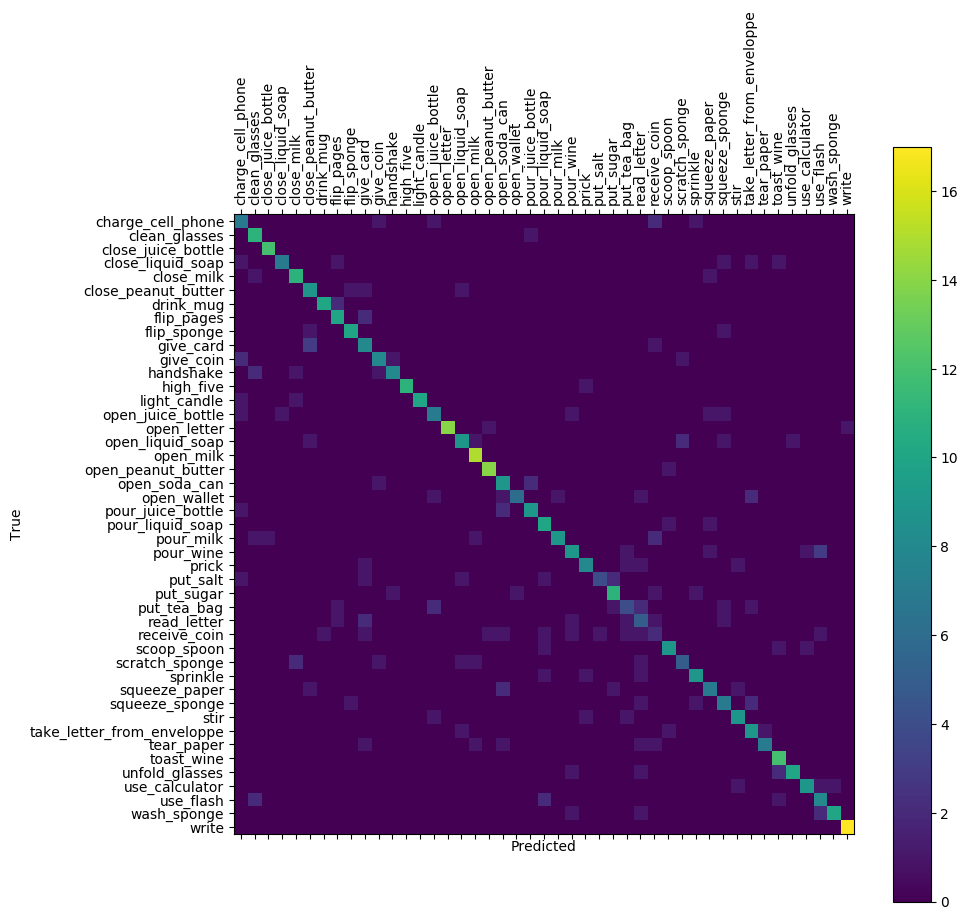

In [33]:
# Import RNN and test
pred_labels, true_labels = useStandardRNN()

Interpreted group Motion Accuracy 73.29 % with 13 groups


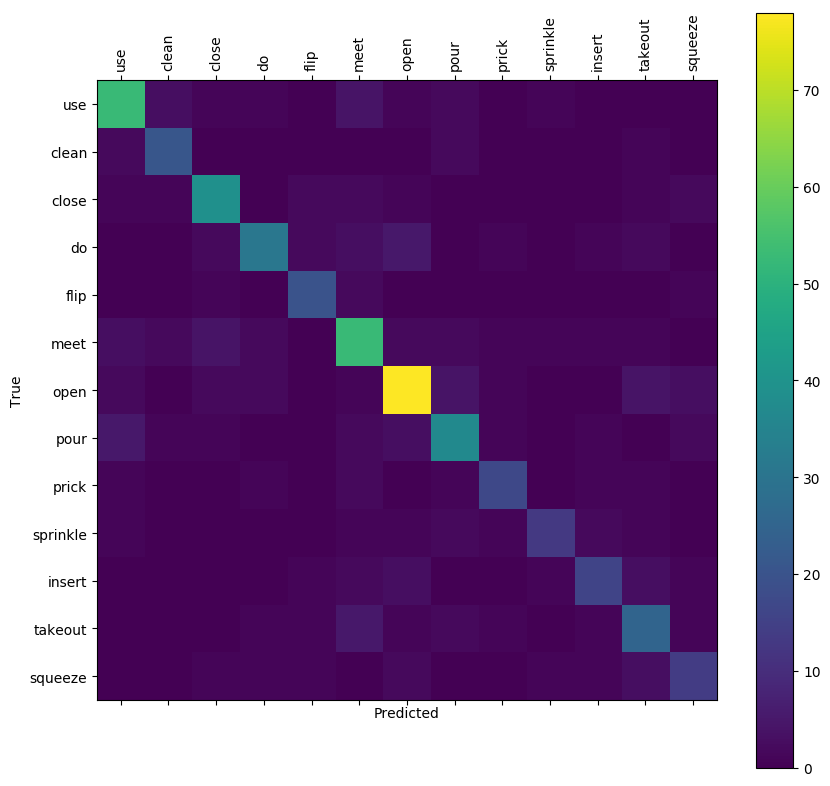

In [38]:
#Interpret results if had been part of a group

#familyA = 'Object' 
familyA ='Motion'
#directoryA = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/grouping_1/'
directoryA = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/grouping_2/'

label_locationA = directoryA + 'labels/' + familyA + '_group_labels.txt' 
(atogA, _, g_labelsA) = action_to_group(label_locationA, familyA)
evaluate_grouping (pred_labels, true_labels, atogA, g_labelsA, familyA)

**Execution - Group RNN **


In [ ]:
#Train group RNN on classifying the object group
doMyRNN(family, -1) #-1 as this is a main group net (not subnet)

In [ ]:
#Analyze group RNN results
pred_labels = useGroupRNN()

#Save output to feed to subnet
location = directory + 'results/group_RNN/' + family + '/'
np.save(location + 'pred_labels.npy', pred_labels) 

**Subnets RNN **

In [ ]:
#Train subnets independently of group RNN 

#Build a subnet for all groups
n_epochs = 100 #smaller training for smaller nets
for group_number in groups_with_subnet:

    num_classes = gtoa[group_number] #number of classes
    
    #Trained subnet are saved in doMyRNN
    doMyRNN(family, group_number)
    #Subnets are just like the orginal RNN but with a selected number of training samples from training.txt and testing.txt

In [11]:
    #Evaluate the subnet after its training
    #acc = np.mean(np.equal(true_labels, pred_labels))
    #print('Group %i "%s" - %s - accuracy: %.2f %%' % (group_number, g_labels[group_number], group_sub_labels, float(100*acc)))
    #print(pred_labels); print(true_labels); print(np.equal(true_labels, pred_labels))
    #location = directory + 'labels/name_of_labels_original.txt'
    #group_sub_labels = get_group_labels(location, atog, group_number) #labels of classes (inside this group)
    #confusion_mtx(true_labels, pred_labels, group_sub_labels)

**Final group+subnet RNN **

In [12]:
#Load data & Compute groupRNN accuracy on 1 action and multi action groups

#Obtain all original data
(test_data, test_labels, test_lengths) = create_dataset(file_testing, -2)
test_data, test_labels, test_lengths = np.asarray(test_data), np.asarray(test_labels), np.asarray(test_lengths) 

#Link groupRNN output to subnets input using pred_labels
location = directory + 'results/group_RNN/' + family + '/'
pred_labels = np.load(location + 'pred_labels.npy') 

if not groups_without_subnet: #means list is empty (no 1 action groups)
    correct_pred_without, accuracy_without = [], 0
else: #1 action groups exist
    correct_pred_without = compute_accuracy(groups_without_subnet, pred_labels, test_labels)
    accuracy_without = np.mean(correct_pred_without) 
correct_pred_with = compute_accuracy(groups_with_subnet, pred_labels, test_labels)
accuracy_with = np.mean(correct_pred_with) 
print("Accuracy of groupRNN only on 1 and multi action groups: %.2f%% and %.2f%% " % (float(100*accuracy_without), float(100*accuracy_with)) )

Accuracy of groupRNN only on 1 and multi action groups: 0.00% and 70.12% 


In [ ]:
#Analyze overall architecture group+subnet results

#Helps to know what is left to compute
print('Now using subnets for groups ' + str(groups_with_subnet))

#Assume groupRNN 100% pred and evaluate subnet results
correct_pred_with = []
group_test_labels = [atog[value] for value in test_labels] #convert to group number for comparison
for group_number in groups_with_subnet:
    correct_pred = useSubnet(group_number, group_test_labels, test_data, test_labels, test_lengths)
    correct_pred_with = np.append(correct_pred_with, correct_pred) #accumulate results
correct_pred_with_accuracy = np.mean(correct_pred_with)
print('\n Assuming groupRNN is 100%% perfect, accuracy of subnets only: %.2f %% \n' % float(100*correct_pred_with_accuracy))

#Pass groupRNN output through subnets and collect results
correct_pred_with = []
for group_number in groups_with_subnet:
    correct_pred = useSubnet(group_number, pred_labels, test_data, test_labels, test_lengths)
    correct_pred_with = np.append(correct_pred_with, correct_pred) #accumulate results   
correct_pred_with_accuracy = np.mean(correct_pred_with)
print('Using groupRNN output, accuracy of subnets only: %.2f %%' % float(100*correct_pred_with_accuracy)) 
#above should be same as below if no 1 action groups

#Final result
final_pred = np.append(correct_pred_without, correct_pred_with) #add previously known results (groups with 1 action)
final_accuracy = np.mean(final_pred)
print('Final group+subnet accuracy: %.2f %%' % float(100*final_accuracy))

In [25]:
group_number = -4
if group_number == -3: #standard 45 actions RNN
    print('z')
elif group_number == -2: #groupRNN to subnets (testing phase)
    print('a')
elif group_number == -1: #groupRNN
    print('b')
else: #subnets
    print('c')

c
